In [1]:
import pandas as pd
import numpy as np
import json
from itertools import chain
import os
import matplotlib.pyplot as plt
from copy import deepcopy

from preprocessing_utils import ScaleData, SplitData, n_lag_return, LogReturn2SimpleReturn
from sklearn.preprocessing import MinMaxScaler

In [2]:
def GetResultsFromJSON(ticker, fold, exp_dir):
    result_dir = f"{exp_dir}/fold{fold}/{ticker}/model_results.json"
    with open(result_dir, 'r') as f:
        results = json.load(f)
    return results

def FetchBestResults(results):
    best_idx = np.argmin(results['val_losses'])
    best_results = {key: value[best_idx] for key, value in results.items()}
    return best_results

In [3]:
stock_tickers = pd.read_csv('data/SP500_tickers_clean.csv', header=0).Ticker.unique()
stock_data = pd.read_csv('data/SP500_stock_prices_log_clean_3monthreturn_sentiment.csv', index_col=0, parse_dates=True) #!

In [4]:
TEST_SPLITS = ['2018-10-01', 
               '2019-01-01', 
               '2019-04-01', 
               '2019-07-01', 
               '2019-10-01']


In [5]:
# get the experiment names
exp_path = 'experiments_sentiment/' #!
exp_names = os.listdir(exp_path)
exp_names

['exp_cycl_1dh',
 'exp_cycl_1DH',
 'exp_cycl_1dH',
 'exp_cycl_1Dh',
 'exp_plat_2DH',
 'exp_plat_2Dh',
 'exp_plat_2dh',
 'exp_plat_2dH',
 'exp_cycl_2DH',
 'exp_cycl_2Dh',
 'exp_cycl_2dh',
 'exp_cycl_2dH',
 'exp_plat_1dh',
 'exp_plat_1dH',
 'exp_plat_1Dh',
 'exp_plat_1DH']

In [6]:
pred_index_df = pd.DataFrame(index=stock_data.index[stock_data.index >= TEST_SPLITS[4]].unique()).iloc[:63]
pred_index_df

""
Date
2019-10-01
2019-10-02
2019-10-03
2019-10-04
2019-10-07
...
2019-12-23
2019-12-24
2019-12-26


In [40]:
# Empty list to store each ticker's results as a series

target_column = ['log_return_3m']
ticker_rows_train = stock_data.loc[stock_data.index < TEST_SPLITS[4]].copy()

config_means = {}
config_stds = {}

for config in exp_names:
    mean_dict = {}
    std_dict = {}

    # for exp_name in exp_names[0:2]:

    for ticker in stock_tickers:
        exp_dir = os.path.join(exp_path, config)
        results = GetResultsFromJSON(ticker, 4, exp_dir)
        BestResults = FetchBestResults(results) # val_means is 63 long, so for each day we find the best tickers

        target_scaler = MinMaxScaler()
        target_scaler.fit(ticker_rows_train[ticker_rows_train.Ticker == ticker][target_column])

        unscaled_means = target_scaler.inverse_transform(np.array(BestResults['val_means']).reshape(-1,1))
        unscaled_stds = target_scaler.inverse_transform(np.array(BestResults['val_stds']).reshape(-1,1))

        mean_dict[ticker] = LogReturn2SimpleReturn(unscaled_means).squeeze()
        std_dict[ticker] = LogReturn2SimpleReturn(unscaled_stds).squeeze()

    pred_mean_df = pd.DataFrame(mean_dict, index=pred_index_df.index)
    pred_std_df = pd.DataFrame(std_dict, index=pred_index_df.index)

    config_means[config] = pred_mean_df
    config_stds[config] = pred_std_df

config_means['exp_plat_2dH']

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-01,-0.021000,-0.056486,0.010813,0.144119,0.033703,0.060696,0.018969,0.047400,0.012501,-0.069671,...,0.035681,0.013952,0.038463,0.040467,-0.003238,0.035645,0.058466,-0.051035,-0.008260,0.062384
2019-10-02,-0.020166,-0.062833,0.020497,0.140468,0.035211,0.066861,0.029138,0.055965,0.009338,-0.068690,...,0.032415,-0.004161,0.043397,0.055076,-0.008545,0.037981,0.064191,-0.044552,-0.016956,0.065745
2019-10-03,-0.026350,-0.063195,0.018402,0.132264,0.030694,0.056250,0.015063,0.062393,0.017529,-0.061320,...,0.033352,0.013552,0.036881,0.040314,-0.004695,0.031702,0.071533,-0.039532,-0.014129,0.067614
2019-10-04,-0.009291,-0.058824,0.006382,0.142779,0.031428,0.054160,0.024107,0.061507,0.010561,-0.065513,...,0.029127,0.018349,0.035292,0.040574,0.000350,0.031551,0.080401,-0.037459,-0.002922,0.067664
2019-10-07,-0.012660,-0.059302,0.012544,0.139164,0.031643,0.075012,0.020706,0.060651,0.018268,-0.064225,...,0.034523,0.015591,0.042499,0.037334,-0.003897,0.036949,0.078331,-0.028576,0.005225,0.060994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,-0.105586,-0.061771,-0.004308,-0.106977,0.030882,-0.018201,-0.154852,0.006630,-0.005004,-0.070769,...,0.036959,-0.197535,-0.144942,0.029655,-0.005125,0.037112,-0.023094,-0.080617,-0.077547,0.063394
2019-12-24,-0.105294,-0.083073,-0.000831,-0.104640,0.035026,-0.028282,-0.152729,-0.004755,-0.011836,-0.062426,...,0.033706,-0.195258,-0.142697,0.035236,0.000581,0.028036,-0.019429,-0.077135,-0.077070,0.070154
2019-12-26,-0.108417,-0.084151,0.000465,-0.104372,0.030388,-0.012818,-0.162869,0.000941,-0.021459,-0.072438,...,0.027489,-0.205685,-0.154288,0.031963,-0.011102,0.037498,-0.010966,-0.082357,-0.075576,0.063858


<Axes: xlabel='Date'>

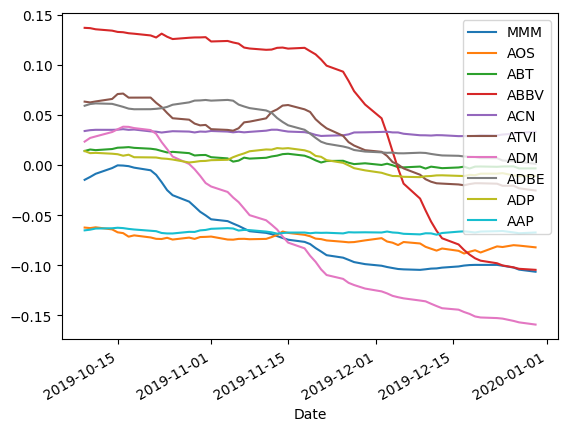

In [41]:
config_means['exp_plat_2dH'].iloc[:,:10].rolling(7).mean().plot()

In [42]:
np.random.seed(42)

plot=False
# Your dataframes: df_returns for daily returns, df_stds for daily standard deviations
# They should have the same shape and share indices and columns
# assert pred_mean_df.shape == pred_std_df.shape
# assert (pred_mean_df.index == pred_std_df.index).all()
# assert (pred_mean_df.columns == pred_std_df.columns).all()

# Set up an array to hold results
n_days, n_assets = pred_mean_df.shape
n_portfolios = 10000  # number of portfolios to simulate each day
days = pred_mean_df.index.strftime('%Y-%m-%d')

config_opt_portfolios = {}

for config in exp_names:

    optimal_portfolios = {}
    
    # Run simulation for each day
    for i in range(n_days):
        # Get mean returns and standard deviations for the day
        means = pred_mean_df.iloc[i].values
        stds = pred_std_df.iloc[i].values

        # Calculate the covariance matrix based on the predicted stds
        cov_matrix = np.diag(stds**2)

        # Arrays to store simulation results
        portfolio_returns = []
        portfolio_risks = []
        portfolio_weights = []
        portfolio_sharpe_ratios = []

        # Generate random portfolios
        for _ in range(n_portfolios):
            random_indices = np.random.choice(n_assets, size=10, replace=False)  # Randomly select 10 indices
            weights = np.zeros(n_assets)  # Initialize weights array
            weights[random_indices] = np.random.dirichlet(np.ones(10))  # Generate random weights for selected indices
            portfolio_weights.append(weights)

            # Calculate portfolio return and risk
            returns = np.dot(weights, means)
            portfolio_returns.append(returns)

            var = np.dot(weights.T, np.dot(cov_matrix, weights))
            portfolio_risks.append(np.sqrt(var))

            # Calculate Sharpe ratio
            sharpe_ratio = (returns - (0.03/4)) / np.sqrt(var) # risk free rate in last quarter of 2019 was 3%
            portfolio_sharpe_ratios.append(sharpe_ratio)

        # Convert to numpy arrays
        portfolio_returns = np.array(portfolio_returns)
        portfolio_risks = np.array(portfolio_risks)
        portfolio_weights = np.array(portfolio_weights)
        portfolio_sharpe_ratios = np.array(portfolio_sharpe_ratios)

        # Identify the portfolio with the highest Sharpe ratio
        max_index = np.argmax(portfolio_sharpe_ratios)
        optimal_risk = portfolio_risks[max_index]
        optimal_return = portfolio_returns[max_index]
        optimal_weights = portfolio_weights[max_index]
        
        # only keep the top 10 weights, but don't change the order and save their original indices
        top_10_weights = optimal_weights.argsort()[-10:][::-1]
        # # sort the weights in descending order
        optimal_weights = optimal_weights[top_10_weights]
        # make sure that the weights add up to 1
        optimal_weights = optimal_weights/sum(optimal_weights)
        # find the corresponding tickers
        optimal_tickers = pred_mean_df.columns[top_10_weights].tolist()
        # print(optimal_tickers, optimal_weights, optimal_return, optimal_risk)
        
        #! saving the optimal portfolio information
        optimal_portfolios[days[i]] = {'tickers': optimal_tickers, 'weights': optimal_weights, 'return': optimal_return, 'risk': optimal_risk}
    
        if plot==True:
            # Plot the efficient frontier for the day
            plt.figure(figsize=(10, 6))
            plt.scatter(portfolio_risks, portfolio_returns, c=portfolio_sharpe_ratios, cmap='viridis', marker='o')
            plt.colorbar(label='Sharpe ratio')
            # Plot the minimum volatility portfolio
            plt.scatter(portfolio_risks[np.argmin(portfolio_risks)], portfolio_returns[np.argmin(portfolio_risks)], color='g', marker='*', s=500) # min volatility portfolio
            plt.scatter(optimal_risk, optimal_return, color='r', marker='*', s=500)  # optimal portfolio

            plt.xlabel('Forecasted Volatility')
            plt.ylabel('Forecasted Return')
            plt.title(f'Efficient Frontier for Day {i+1}')
            plt.legend()
            plt.show()


    optimal_weights_df = pd.DataFrame.from_dict(optimal_portfolios, orient='index')
    optimal_weights_df.index = pred_index_df.index
    
    config_opt_portfolios[config] = optimal_weights_df


In [43]:
for config in exp_names: 
    config_opt_portfolios[config].to_csv(f"data/LSTM/LSTM_results_optimal_sentiment_{config}.csv", index=True)

In [9]:
target_column = ['log_return_3m']
ticker_rows_train = stock_data.loc[stock_data.index < TEST_SPLITS[4]].copy()

mean_dict = {}
std_dict = {}
best_days = []

# for exp_name in exp_names[0:2]:

for ticker in stock_tickers:
    exp_dir = os.path.join(exp_path, 'exp_plat_1dH')
    results = GetResultsFromJSON(ticker, 4, exp_dir)
    BestResults = FetchBestResults(results) # val_means is 63 long, so for each day we find the best tickers

    target_scaler = MinMaxScaler()
    target_scaler.fit(ticker_rows_train[ticker_rows_train.Ticker == ticker][target_column])

    unscaled_means = target_scaler.inverse_transform(np.array(BestResults['val_means']).reshape(-1,1))
    unscaled_stds = target_scaler.inverse_transform(np.array(BestResults['val_stds']).reshape(-1,1))

    best_days.append(np.argmin(results['val_losses']))

    mean_dict[ticker] = LogReturn2SimpleReturn(unscaled_means).squeeze()
    std_dict[ticker] = LogReturn2SimpleReturn(unscaled_stds).squeeze()

pred_mean_df = pd.DataFrame(mean_dict, index=pred_index_df.index)
pred_std_df = pd.DataFrame(std_dict, index=pred_index_df.index)

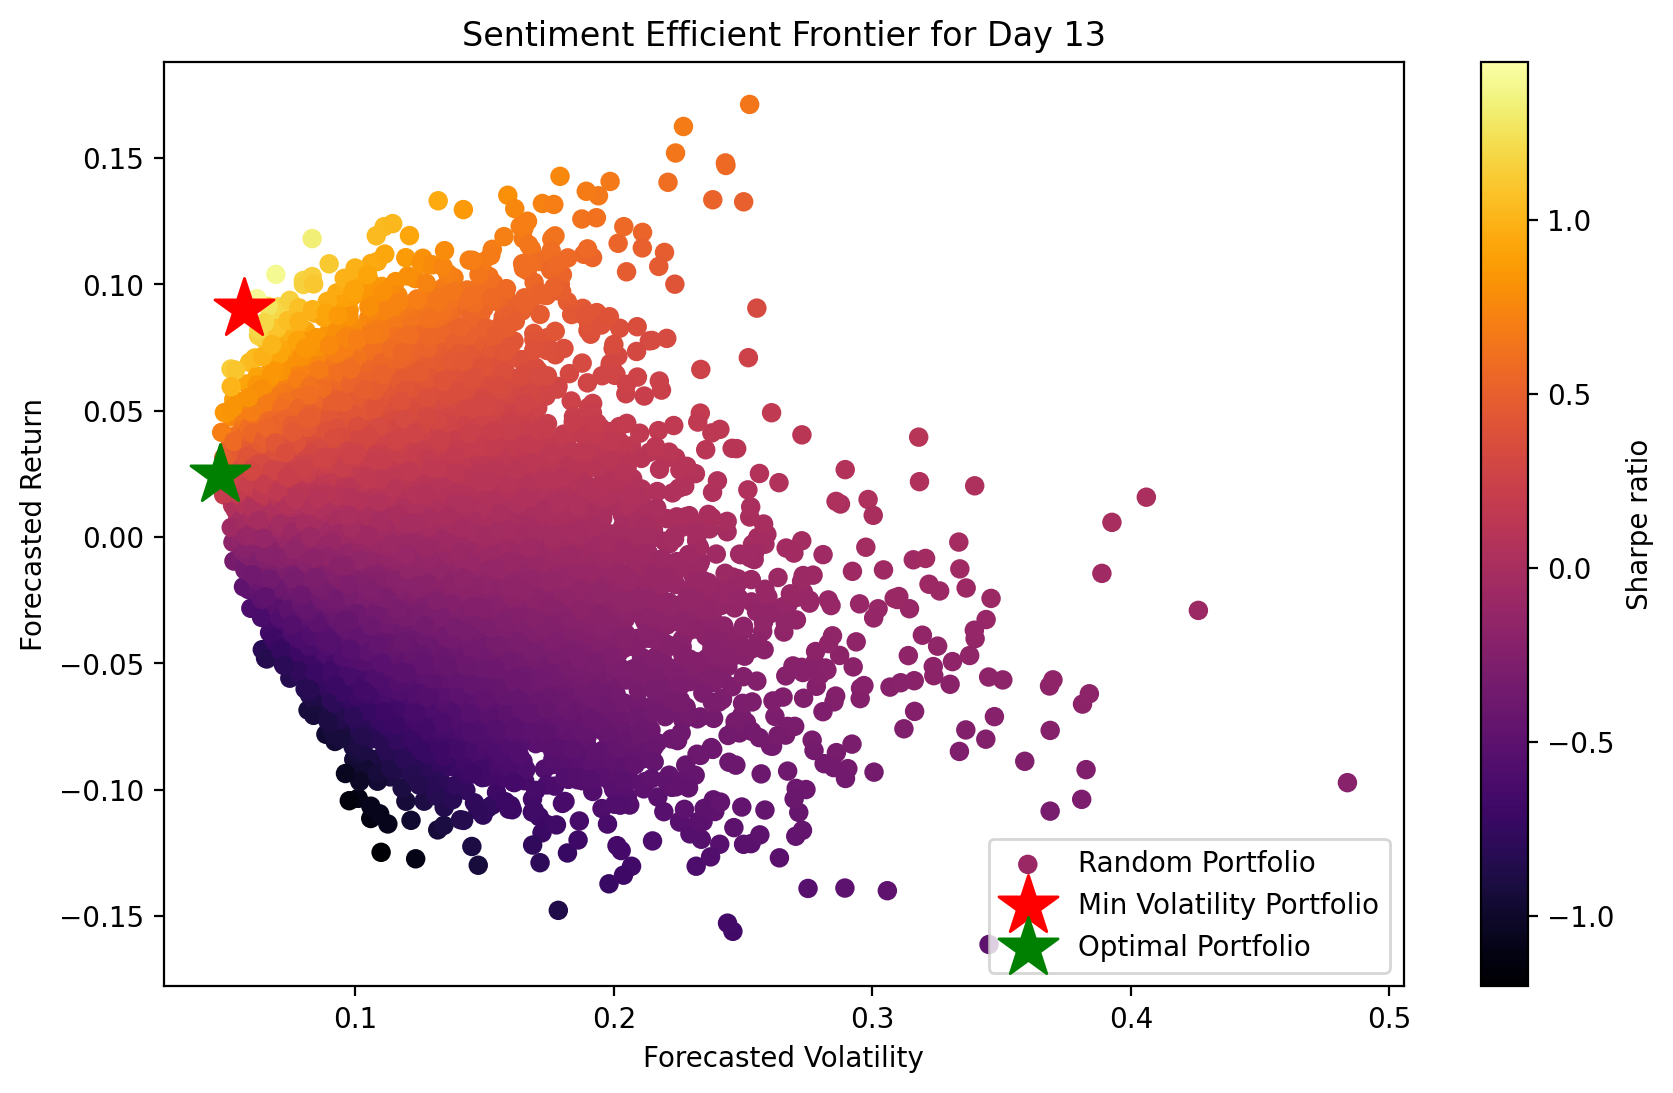

In [12]:
np.random.seed(19)

plot=True

# Set up an array to hold results
n_days, n_assets = pred_mean_df.shape
n_portfolios = 50000  # number of portfolios to simulate each day
days = pred_mean_df.index.strftime('%Y-%m-%d')

optimal_portfolios = {}
    
# Run simulation for the lowest val_error day
best_day = int(np.median(best_days))

means = pred_mean_df.iloc[best_day].values
stds = pred_std_df.iloc[best_day].values

# Calculate the covariance matrix based on the predicted stds
cov_matrix = np.diag(stds**2)

# Arrays to store simulation results
portfolio_returns = []
portfolio_risks = []
portfolio_weights = []
portfolio_sharpe_ratios = []

# Generate random portfolios
for _ in range(n_portfolios):
    random_indices = np.random.choice(n_assets, size=10, replace=False)  # Randomly select 10 indices
    weights = np.zeros(n_assets)  # Initialize weights array
    weights[random_indices] = np.random.dirichlet(np.ones(10))  # Generate random weights for selected indices
    portfolio_weights.append(weights)

    # Calculate portfolio return and risk
    returns = np.dot(weights, means)
    portfolio_returns.append(returns)

    var = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_risks.append(np.sqrt(var))

    # Calculate Sharpe ratio
    sharpe_ratio = (returns - (0.03/4)) / np.sqrt(var) # risk free rate in last quarter of 2019 was 3%
    portfolio_sharpe_ratios.append(sharpe_ratio)

# Convert to numpy arrays
portfolio_returns = np.array(portfolio_returns)
portfolio_risks = np.array(portfolio_risks)
portfolio_weights = np.array(portfolio_weights)
portfolio_sharpe_ratios = np.array(portfolio_sharpe_ratios)

# Identify the portfolio with the highest Sharpe ratio
max_index = np.argmax(portfolio_sharpe_ratios)
optimal_risk = portfolio_risks[max_index]
optimal_return = portfolio_returns[max_index]
optimal_weights = portfolio_weights[max_index]

# only keep the top 10 weights, but don't change the order and save their original indices
top_10_weights = optimal_weights.argsort()[-10:][::-1]
# # sort the weights in descending order
optimal_weights = optimal_weights[top_10_weights]
# make sure that the weights add up to 1
optimal_weights = optimal_weights/sum(optimal_weights)
# find the corresponding tickers
optimal_tickers = pred_mean_df.columns[top_10_weights].tolist()
# print(optimal_tickers, optimal_weights, optimal_return, optimal_risk)

# ! saving the optimal portfolio information
# optimal_portfolios = {'tickers': optimal_tickers, 'weights': optimal_weights, 'return': optimal_return, 'risk': optimal_risk}

if plot==True:
    # Plot the efficient frontier for the day
    plt.figure(figsize=(10, 6), dpi=200)
    plt.scatter(portfolio_risks, portfolio_returns, c=portfolio_sharpe_ratios, cmap='inferno', marker='o', alpha=1)
    plt.colorbar(label='Sharpe ratio')
    # Plot the minimum volatility portfolio
    plt.scatter(optimal_risk, optimal_return, color='r', marker='*', s=500)  # optimal portfolio
    plt.scatter(portfolio_risks[np.argmin(portfolio_risks)], portfolio_returns[np.argmin(portfolio_risks)], color='g', marker='*', s=500) # min volatility portfolio

    plt.xlabel('Forecasted Volatility')
    plt.ylabel('Forecasted Return')
    plt.title(f'Sentiment Efficient Frontier for Day {best_day+1}')
    plt.legend(['Random Portfolio','Optimal Portfolio', 'Min Volatility Portfolio'], loc='lower right')
    plt.show()